# Hospitalization Prediction for Elderly People.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, classification_report, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, PowerTransformer

from src.eda import *
from src.config import *
from src.data_extract import *
from src import feature_selection as fs
from src.evaluation import *


# 1. Data Extract


* The dataset is the *Mexican Health and Aging Study* **MHAS**, a longitudinal household survey dataset for the study of health, economic position, and quality of life among the elderly.
the survey was performed during 5 periods of time, technically known as **Waves**. Furthermore there are three study subjects: the Respondents (r), the Spouse (s) and finally the Households (H). In this study the first two study subject was taken.
* Bearing on mind the survey nature of the dataset it is plaussible to think the features are encoded, instead of holding a intuitive name. For that reason in the following we are forced refering the variable names by their code-name. But don't worry, we will try to attach its meaning so it will be understandable.




## 1.1. Load the data

* Originally the data is freely available in the **MHAS** official webpage. But due its raw format (a SAS one) we considered working over it as DataFrame.
* It is important to notice the dataset has a CodeBook showing the meaning and the measure methodology, among other important quantitative features.

In [2]:
# download, unzip and load the data as DataFrame on the sake of practicality.
mhas = get_data_frame()

Current directory: c:\Users\Leo\OneDrive\Escritorio\Nueva carpeta\hospitalization-prediction\model_traning
ZIP file already extracted.



## 1.2. Extract the data.

* As was mentioned earlier, this study will consider the Respondent and the Spouse as main study subject. 
* In adittion to that we decided to take into account all the waves together.
* It is important to notice there are  no-common features in all waves. Fortunately these features are few and easily we can ignore them.
* To sum up, in order to get the data ready for the EDA and subsequent modeling we took into account common columns/features along with Respondant and Spouse considering all the waves and merging them into one unique Dataframe.

In [3]:
df = extract(mhas)

c:\Users\Leo\OneDrive\Escritorio\Nueva carpeta\hospitalization-prediction\model_traning\src\data_extract.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s1[p1] = df[s1].copy()
c:\Users\Leo\OneDrive\Escritorio\Nueva carpeta\hospitalization-prediction\model_traning\src\data_extract.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s1[p1] = df[s1].copy()
c:\Users\Leo\OneDrive\Escritorio\Nueva carpeta\hospitalization-prediction\model_traning\src\data_extract.py:98: PerformanceWarning: DataFrame is highly fragmented.  T

In [4]:
df.shape

(268390, 444)

# 2. EDA.
* **Data Strucuture**: The dataset is divided among many sections enconded in non-conscutive letters.
*  Specifically, in 15 sections. Each of them quantifying several aspects related to the healt and socioeconomic aspects.

1. Section A: Demographics, Identifiers, and Weights
2. Section B: Health
3. Section C: Health Care Utilization and Insurance
4. Section D: Cognition
5. Section E: Financial and Housing Wealth
6. Section F: Income
7. Section G: Family Structure
8. Section H: Employment History
9. Section I: Retirement
10. Section J: Pension
11. Section K: Physical Measures
12. Section L: Assistance and Caregiving
13. Section M: Stress
14. Section O: End of Life Planning
15. Section Q: Psychosocial

## 2.1. Identifying the target Variable.
* The target variable belongs to the *section C: Health Care Utilization and Insurance*, name it as **Medical Care Utilization: Hospital** `owhosp1y` wehere the **o** can be "s" or "r", and "w" gos from 1 to 5. But in this study was renamed as `pahosp1y`
* Its definition according to the Codebook is: *indicates whether the respondent reports at least one overnight hospital stay in the last 12 months, is coded as 0 if the respondent had no overnight hospital stays, and is coded as 1 if the respondent had at least one overnight hospital stay*
* as we can see in the following plot, the data is imbalanced.


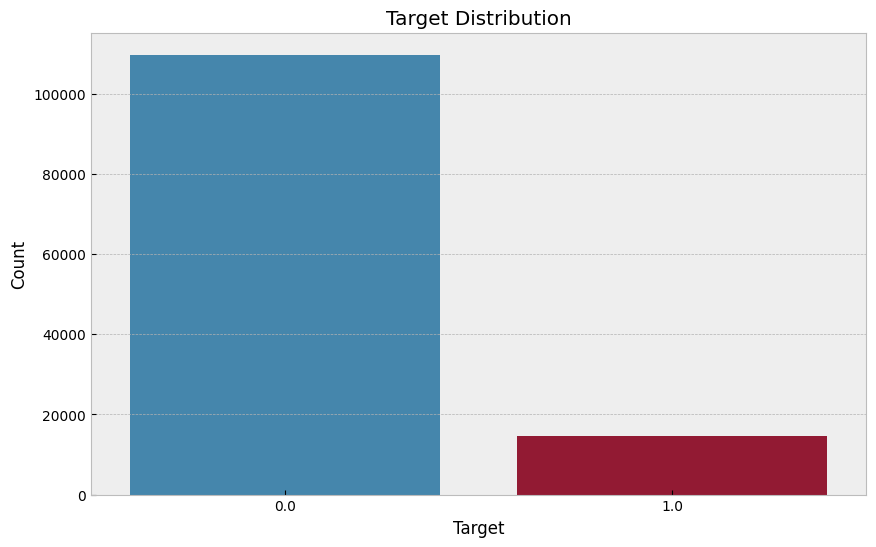

In [5]:
# renaming the dataframe for convenience
target = "pahosp1y"

# plottiing the unique values of the target to spot imbalance}
with plt.style.context('bmh'):
        plt.figure(figsize=(10, 6))
        ax = sns.countplot(x=target, data=df, linewidth=0)
        ax.set_xlabel("Target")
        ax.set_ylabel("Count")
        ax.set_title("Target Distribution")
        plt.show()

## 2.2. Missing values.
* The the number of features the data has is 444. Where most of them has high porportion of missing values.
* Th reason behind this comnes from two sides. firt, many of surveyed people was not at home in the survey time (this is stressed in the codebook); and the second reason is the survey question nature: Most of them are dependnt events, which means it depens on the answer of a couple of prevoius questions, resulting in an *if* strcuture (if the first question is answered then the second question could be answered or not, again, it depends on what the question is intented to measure)

the number of features tyhe data has is: 444


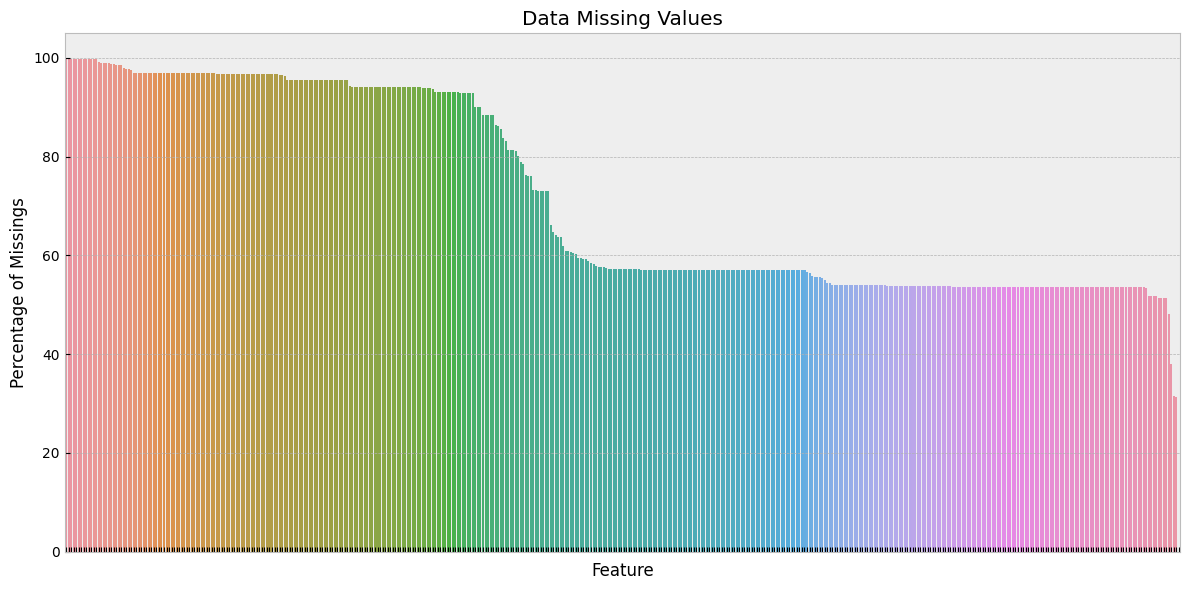

In [6]:
print(f"the number of features tyhe data has is: {df.shape[1]}")
plot_missing_values(df)

## 2.3. Data type and unique values.
* From the graph we an spot that most of the data has **binary** values (this is 0 and 1), The other proportion is made up by **discrete** values (from 0 to 10 in most cases), and finally, even few of features has **continuous** values.
* This fact, in principle constraints a lot the **data representativeness** due the lack of information. This can be spotted by looking at diseases variables, to mention few. Rather than having more informative measure in diseases and its types, the survey only consider whether the surveyed person has or not a certain disease.

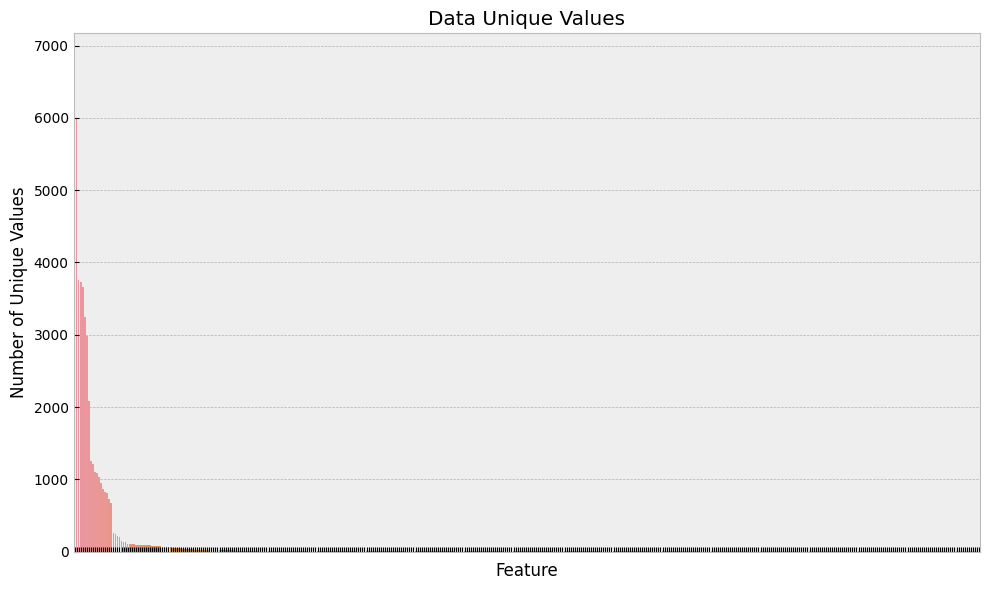

In [7]:
plot_uniques(df)

## 2.4. Correlation between binary features and the target.
* we can observe a clear relationship between the features and the target variables. The next plor shows a correlation measured trought o the Cramer's V score, which provides a measure of how strongly two categorical variables are associated. It helps in understanding the relationship between variables and can be useful in feature selection, variable importance analysis, and exploratory data analysis.

c:\Users\Leo\OneDrive\Escritorio\Nueva carpeta\hospitalization-prediction\model_traning\src\eda.py:208: RuntimeWarning: invalid value encountered in scalar divide
  V = np.sqrt(phi_c / min(contingency_table.shape[0] - 1, contingency_table.shape[1] - 1))


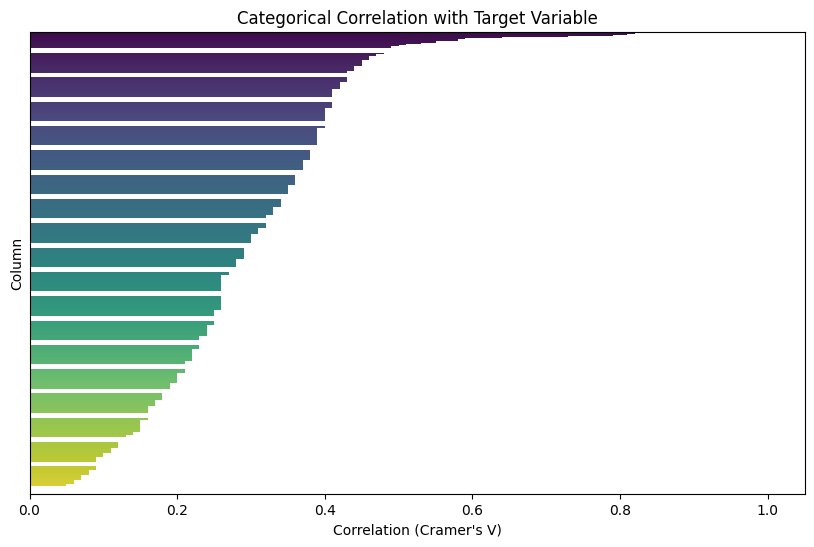

In [8]:
plot_categorical_correlation(df, target)

# 3. Modeling


* Once the feature selection was performed, we 

In [9]:
# filtering the data by elderly people only.
df = df.loc[df['paagey']>=50]

# The selected features, we believe are relevant to the model.
selected=['pahosp1y','pahipe_m', 'padadage', 'pamomage', 
          'pahibpe', 'palunge_m', 'pacholst', 'pagrossaa', 
          'paosleep', 'pafallinj', 'pacancre', 'paswell', 
          'pachair', 'parafaany', 'pawheeze', 'paagey', 
          'paarthre', 'padiabe', 'parjudg', 'paweight', 
          'paclims', 'pastroke', 'pabathehlp', 'pasmokev', 
          'pahearaid', 'pameds', 'paheight', 'paglasses', 
          'paeat', 'papaina', 'pagender', 'padrinkb']

print(f"There are {len(selected)} features selected")

df3 = df.where(df['cpindex'] <=  109).dropna(subset=['cpindex'])

df_s = df3.dropna(subset=[target]) 
df_s = df_s[selected].copy()

nulls_percentage = df_s.isnull().sum(axis=1) / len(df.columns)
df_s = df_s[(df_s[target] != 0) | (nulls_percentage <= 0.5)]

# splitting the data into X and y
y = df_s[target]
X = df_s.drop(target,axis=1)

#filling thge nulls
X = fs.fast_fill(X)
X=X.sort_index(axis=1)
# Scaling the data
scaler = StandardScaler()
X=scaler.fit_transform(X)
# Normalizing the data
transformer = PowerTransformer(method='yeo-johnson')
X=transformer.fit_transform(X)

# 63.29
# 73.90
# 107.69
# 119.40
# 136.6
X.shape 

There are 32 features selected


(68619, 31)

In [17]:
# creating variables that captures the proportion of classes in the target.
zeros=y.value_counts()[0]
ones=y.value_counts()[1]

# This are the parameters that we found to be the best for the model.
params={
        'max_depth': 7, 
        'subsample': 0.759545947005226,
        'colsample_bytree': 0.9075616505206274, 
        'eta': 0.05568753700048324, 
        'min_child_weight': 5, 
        'learning_rate': 0.0999908981133205, 
        'n_estimators': 560,
        'scale_pos_weight': (zeros/ones)-2.5,
        'n_jobs':-1,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss'
}

# instantiating the model
model = XGBClassifier(**params)

# 4. Evaluating

In [18]:
kf = KFold(n_splits=7)

y_test_all = []
y_pred_all = []
y_pred_prob_all = []


for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train)
    
    y_test_all.extend(y_test)
    y_pred_all.extend(model.predict(X_test))
    y_pred_prob_all.extend(model.predict_proba(X_test))

In [ ]:
# Convertir las listas en arrays numpy
y_test_all = np.array(y_test_all)
y_pred_all = np.array(y_pred_all)
y_pred_prob_all = np.array(y_pred_prob_all)[:, 1]

# Calcular el AUC
auc = roc_auc_score(y_test_all, y_pred_prob_all)

# Calcular el classification_report
report = classification_report(y_test_all, y_pred_all)

print(f'AUC: {auc}')
print(report)

AUC: 0.937910056104865
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     61314
         1.0       0.83      0.81      0.82      7305

    accuracy                           0.96     68619
   macro avg       0.90      0.89      0.90     68619
weighted avg       0.96      0.96      0.96     68619



In [ ]:
import joblib

joblib.dump(model,'model.pkl')
joblib.dump(scaler,'scaler.pkl')
joblib.dump(transformer,'transformer.pkl')

['transformer.pkl']

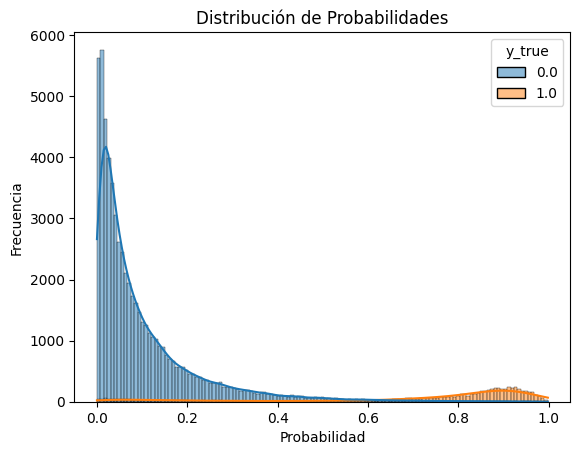

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear un DataFrame con las etiquetas de prueba y las probabilidades predichas
data = pd.DataFrame({'y_true': y_test_all, 'y_pred_prob': y_pred_prob_all})

# Graficar la distribución de probabilidades
sns.histplot(data=data, x='y_pred_prob', hue='y_true', kde=True)

# Agregar etiquetas y título al gráfico
plt.xlabel('Probabilidad')
plt.ylabel('Frecuencia')
plt.title('Distribución de Probabilidades')

# Mostrar el gráfico
plt.show()

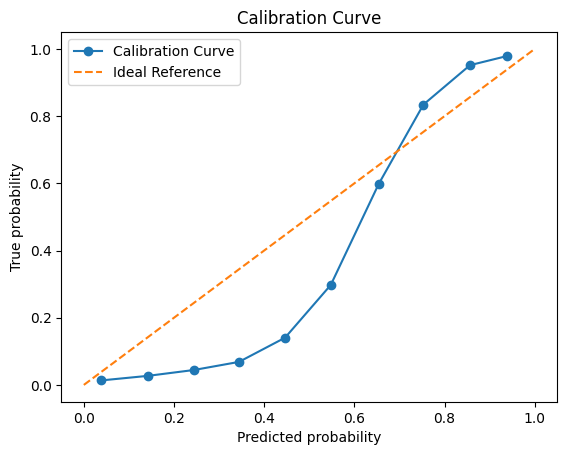

In [ ]:
from sklearn.calibration import calibration_curve
# Calcular la curva de calibración
prob_true, prob_pred = calibration_curve(y_test_all, y_pred_prob_all, n_bins=10)

# Graficar la curva de calibración
plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label='Calibration Curve')

# Graficar la línea de referencia ideal
plt.plot([0, 1], [0, 1], linestyle='--', label='Ideal Reference')

# Configurar los ejes y la leyenda
plt.xlabel('Predicted probability')
plt.ylabel('True probability')
plt.title('Calibration Curve')
plt.legend()

# Mostrar el gráfico
plt.show()

In [ ]:
import joblib

joblib.dump(scaler,'scaler.pkl')
joblib.dump(transformer,'transformer.pkl')
joblib.dump(model,'model.pkl')

['model.pkl']